# 🤪 WGANs on CelebA Faces - Train

In this notebook, we'll walk through the steps required to train your own GAN on the CelebA faces dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, Activation, Dropout, BatchNormalization, LeakyReLU, UpSampling2D, ReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import preprocess, display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
VALIDATION_SPLIT = 0.2
Z_DIM = 128
LEARNING_RATE = 0.0002
KERNEL_SIZE = 5
EPOCHS = 20
CRITIC_ITERATIONS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = True

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
train_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "/app/data/celeba-dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [5]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

In [6]:
# Show some faces from the training set
train_sample = sample_batch(train)
test_sample = sample_batch(test)

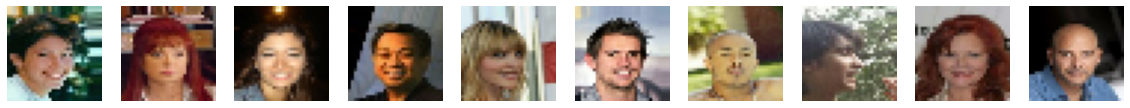

In [7]:
display(train_sample, cmap = None)

## 2. Build the GAN <a name="build"></a>

In [8]:
critic_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(NUM_FEATURES, kernel_size=KERNEL_SIZE, strides=2, padding="same")(critic_input)
x = LeakyReLU(0.2)(x)
x = Conv2D(NUM_FEATURES * 2, kernel_size=KERNEL_SIZE, strides=2, padding="same")(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)
x = Conv2D(NUM_FEATURES * 4, kernel_size=KERNEL_SIZE, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)
x = Conv2D(NUM_FEATURES * 8, kernel_size=KERNEL_SIZE, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)
critic_output = Dense(1)(x)

critic = Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456

In [9]:
generator_input = Input(shape=(Z_DIM,))
x = Dense(4*4*256, use_bias=False)(generator_input)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = Reshape((4,4,256))(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES * 2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = UpSampling2D()(x)
x = Conv2D(NUM_FEATURES, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
x = UpSampling2D()(x)
x = Conv2D(CHANNELS, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
generator_output = Activation('tanh')(x)
generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              524288    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                         

In [10]:
class WGAN(Model):
    def __init__(self, critic, generator, latent_dim, critic_extra_steps, gp_weight):
        super(WGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = critic_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = Mean(name="d_loss")
        self.g_loss_metric = Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the critic loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the critic output for this interpolated image.
            pred = self.critic(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def d_loss_fun(self, real_predictions, fake_predictions):
        real_loss = tf.reduce_mean(real_predictions)
        fake_loss = tf.reduce_mean(fake_predictions)
        return fake_loss - real_loss
    
    def g_loss_fn(self, fake_predictions):
        return -tf.reduce_mean(fake_predictions)

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            # Train the critic on fake images
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training = True)
                fake_predictions = self.critic(fake_images, training = True)
                real_predictions = self.critic(real_images, training = True)
                
                d_cost = self.d_loss_fun(real_predictions, fake_predictions)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight
                
            d_gradient = tape.gradient(d_loss, self.critic.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the critic logits for fake images
            gen_img_logits = self.critic(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [11]:
# Create a GAN
wgan = WGAN(critic=critic, generator=generator, latent_dim=Z_DIM
           , critic_extra_steps = CRITIC_ITERATIONS, gp_weight = GP_WEIGHT)

In [12]:
if LOAD_MODEL:
    wgan.load_weights('./checkpoint/checkpoint.ckpt')

## 3. Train the GAN <a name="train"></a>

In [18]:
# Compile the GAN
wgan.compile(
    d_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9),
    g_optimizer=Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9),
)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs2")

class ImageGenerator(Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)
        

Epoch 52/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0745 - g_loss: -1.1686
Saved to ./output/generated_img_051.png


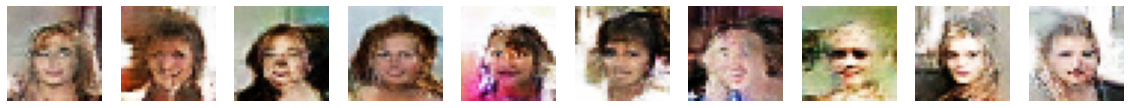

100/100 [==============================] - 124s 1s/step - d_loss: -2.0745 - g_loss: -1.1686
Epoch 53/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0695 - g_loss: 0.7884
Saved to ./output/generated_img_052.png


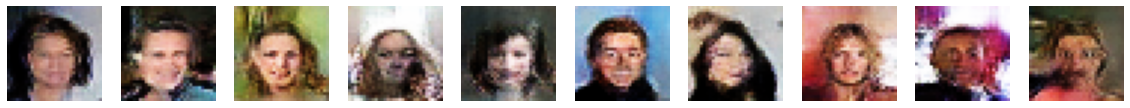

100/100 [==============================] - 123s 1s/step - d_loss: -2.0695 - g_loss: 0.7884
Epoch 54/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0509 - g_loss: -0.0289
Saved to ./output/generated_img_053.png


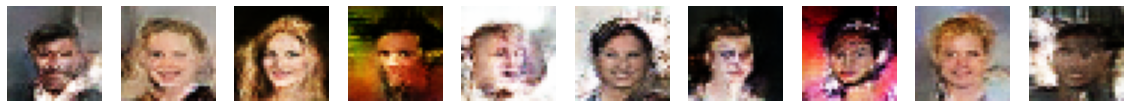

100/100 [==============================] - 123s 1s/step - d_loss: -2.0509 - g_loss: -0.0289
Epoch 55/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0377 - g_loss: -0.4326
Saved to ./output/generated_img_054.png


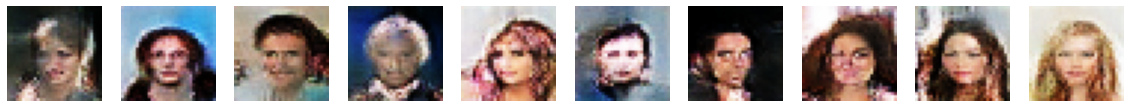

100/100 [==============================] - 123s 1s/step - d_loss: -2.0377 - g_loss: -0.4326
Epoch 56/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0254 - g_loss: 0.1579
Saved to ./output/generated_img_055.png


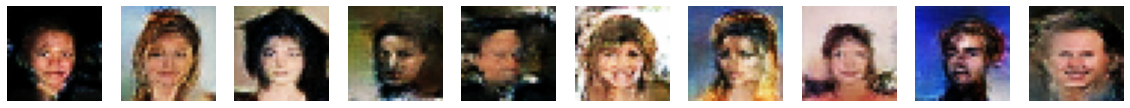

100/100 [==============================] - 123s 1s/step - d_loss: -2.0254 - g_loss: 0.1579
Epoch 57/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0173 - g_loss: 0.6031
Saved to ./output/generated_img_056.png


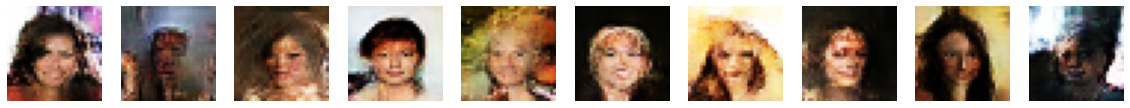

100/100 [==============================] - 123s 1s/step - d_loss: -2.0173 - g_loss: 0.6031
Epoch 58/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0270 - g_loss: -0.8345
Saved to ./output/generated_img_057.png


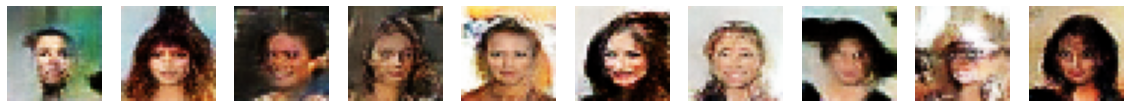

100/100 [==============================] - 123s 1s/step - d_loss: -2.0270 - g_loss: -0.8345
Epoch 59/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0169 - g_loss: 1.6294
Saved to ./output/generated_img_058.png


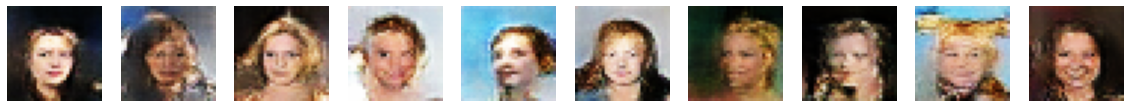

100/100 [==============================] - 123s 1s/step - d_loss: -2.0169 - g_loss: 1.6294
Epoch 60/2000
100/100 [==============================] - ETA: 0s - d_loss: -2.0265 - g_loss: 0.6622
Saved to ./output/generated_img_059.png


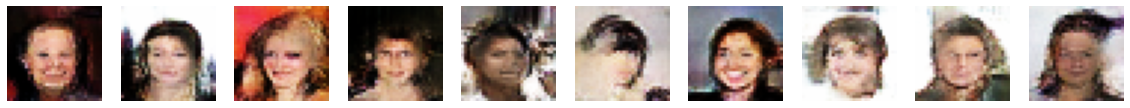

100/100 [==============================] - 123s 1s/step - d_loss: -2.0265 - g_loss: 0.6622
Epoch 61/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9772 - g_loss: 0.0067
Saved to ./output/generated_img_060.png


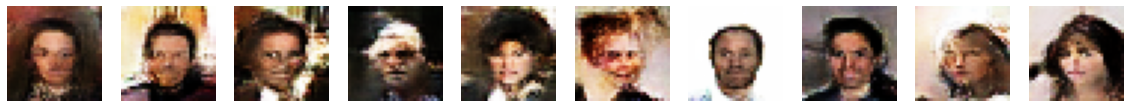

100/100 [==============================] - 123s 1s/step - d_loss: -1.9772 - g_loss: 0.0067
Epoch 62/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9768 - g_loss: 0.0063 
Saved to ./output/generated_img_061.png


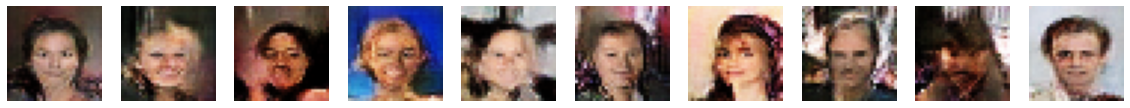

100/100 [==============================] - 123s 1s/step - d_loss: -1.9768 - g_loss: 0.0063
Epoch 63/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9577 - g_loss: 0.1859
Saved to ./output/generated_img_062.png


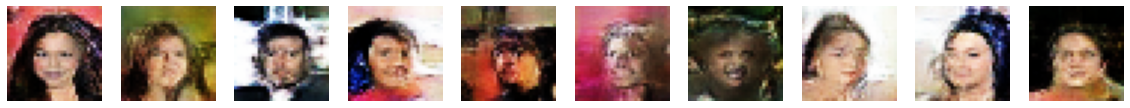

100/100 [==============================] - 124s 1s/step - d_loss: -1.9577 - g_loss: 0.1859
Epoch 64/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9645 - g_loss: -0.2751
Saved to ./output/generated_img_063.png


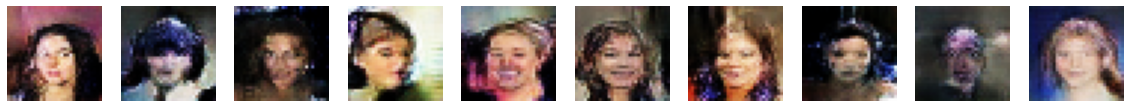

100/100 [==============================] - 123s 1s/step - d_loss: -1.9645 - g_loss: -0.2751
Epoch 65/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9443 - g_loss: 0.1090
Saved to ./output/generated_img_064.png


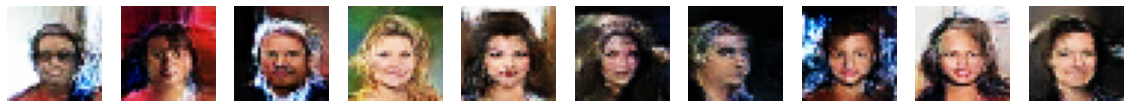

100/100 [==============================] - 123s 1s/step - d_loss: -1.9443 - g_loss: 0.1090
Epoch 66/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9473 - g_loss: -0.0137
Saved to ./output/generated_img_065.png


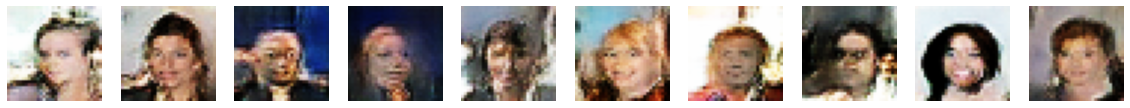

100/100 [==============================] - 123s 1s/step - d_loss: -1.9473 - g_loss: -0.0137
Epoch 67/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9153 - g_loss: -0.1336
Saved to ./output/generated_img_066.png


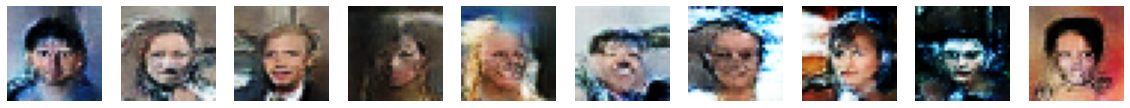

100/100 [==============================] - 123s 1s/step - d_loss: -1.9153 - g_loss: -0.1336
Epoch 68/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9721 - g_loss: -0.9722
Saved to ./output/generated_img_067.png


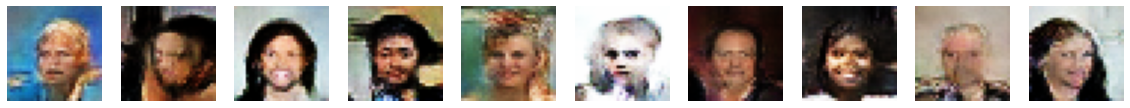

100/100 [==============================] - 123s 1s/step - d_loss: -1.9721 - g_loss: -0.9722
Epoch 69/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9420 - g_loss: 0.4710
Saved to ./output/generated_img_068.png


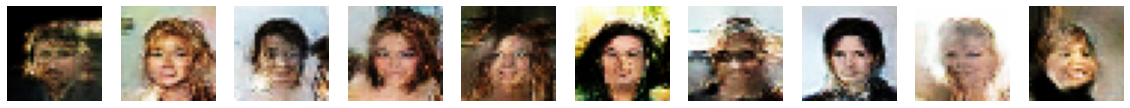

100/100 [==============================] - 123s 1s/step - d_loss: -1.9420 - g_loss: 0.4710
Epoch 70/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9130 - g_loss: 0.4438
Saved to ./output/generated_img_069.png


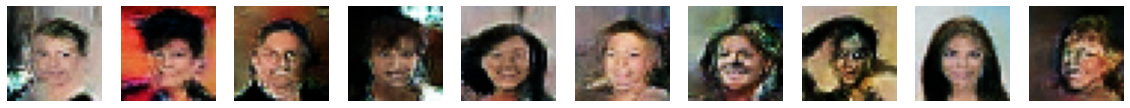

100/100 [==============================] - 123s 1s/step - d_loss: -1.9130 - g_loss: 0.4438
Epoch 71/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.9138 - g_loss: -1.1981
Saved to ./output/generated_img_070.png


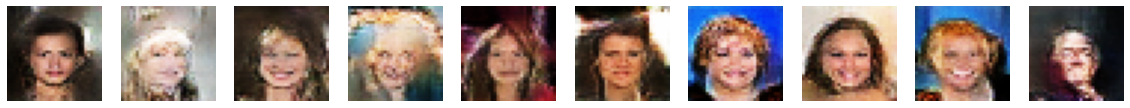

100/100 [==============================] - 123s 1s/step - d_loss: -1.9138 - g_loss: -1.1981
Epoch 72/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.8998 - g_loss: -0.1567
Saved to ./output/generated_img_071.png


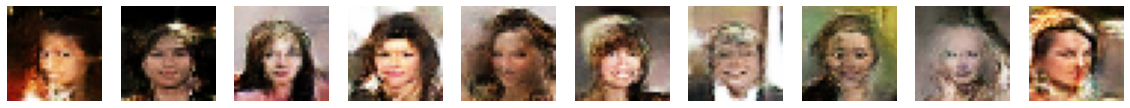

100/100 [==============================] - 123s 1s/step - d_loss: -1.8998 - g_loss: -0.1567
Epoch 73/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.8936 - g_loss: 0.5806
Saved to ./output/generated_img_072.png


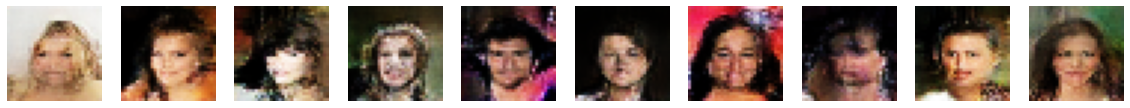

100/100 [==============================] - 123s 1s/step - d_loss: -1.8936 - g_loss: 0.5806
Epoch 74/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.8919 - g_loss: -0.5400
Saved to ./output/generated_img_073.png


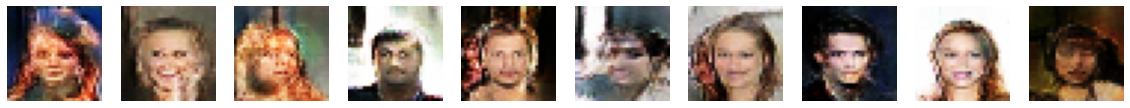

100/100 [==============================] - 123s 1s/step - d_loss: -1.8919 - g_loss: -0.5400
Epoch 75/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.8927 - g_loss: -0.0218
Saved to ./output/generated_img_074.png


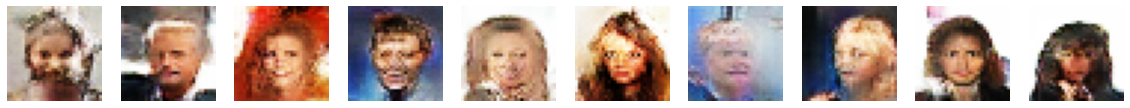

100/100 [==============================] - 123s 1s/step - d_loss: -1.8927 - g_loss: -0.0218
Epoch 76/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.8762 - g_loss: 0.8577
Saved to ./output/generated_img_075.png


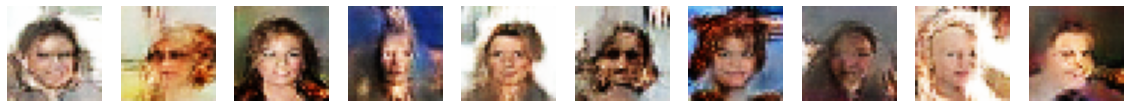

100/100 [==============================] - 123s 1s/step - d_loss: -1.8762 - g_loss: 0.8577
Epoch 77/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.8915 - g_loss: 0.6676
Saved to ./output/generated_img_076.png


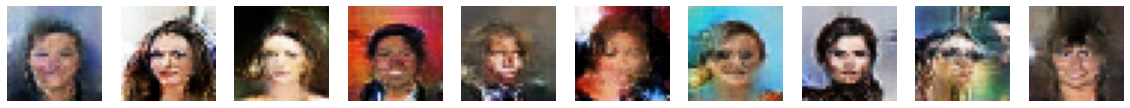

100/100 [==============================] - 124s 1s/step - d_loss: -1.8915 - g_loss: 0.6676
Epoch 78/2000
100/100 [==============================] - ETA: 0s - d_loss: -1.8836 - g_loss: 0.6218
Saved to ./output/generated_img_077.png


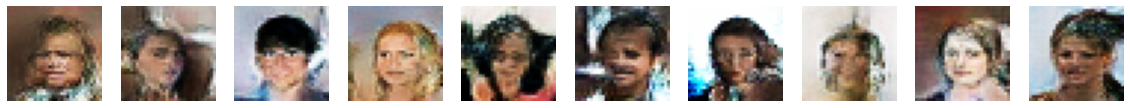

100/100 [==============================] - 123s 1s/step - d_loss: -1.8836 - g_loss: 0.6218
Epoch 79/2000
 57/100 [================>.............] - ETA: 52s - d_loss: -1.8267 - g_loss: -0.0407

In [ ]:
history = wgan.fit(
    train.repeat(), 
    epochs=EPOCHS*100, 
    steps_per_epoch = 100, 
    initial_epoch = 51,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [ ]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

In [ ]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgan.generator.predict(z_sample)
display(imgs, cmap = None)